In [1]:
# Import main packages 
from tilepy.include.ObservationScheduler import GetSchedule
from tilepy.include.PointingTools import ObservationParameters, NextWindowTools, getdate
import time
import argparse
import os
from pathlib import Path


/opt/miniconda3/envs/tilepyenv_1/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
from astropy.io import fits
#skymap = 'https://heasarc.gsfc.nasa.gov/FTP/fermi/data/gbm/triggers/2024/bn240612503/current/glg_healpix_all_bn240612503_v00.fit'
#skymap = 'https://gracedb.ligo.org/api/superevents/S240904bv/files/cwb.multiorder.fits,0'

### Set of inputs needed to run the code

In [4]:
# Type of followup, options: gbm, gbmpng or gw
alertType = 'gbm'

# The url to the FITS file with the sky localization in a healpix format (fits file with name starting by glg_healpix
# Final notice 
#skymap = 'https://heasarc.gsfc.nasa.gov/FTP/fermi/data/gbm/triggers/2024/bn240612503/current/glg_healpix_all_bn240612503_v00.fit'
# Ground notice 
skymap = 'http://gcn.gsfc.nasa.gov/notices_f/gbm_gnd_loc_map_750735938.fits' 

# Date and time of the event in format YYYY-MM-DD HH:MM:SS. You can use 2023-07-15 14:30:10 for the example .fits file
#obsTime = getdate("2023-12-06  23:39:01")
#obsTime = getdate("2024-04-13  02:33:01")
obsTime = getdate("2023-06-10 14:51:47")

# Path to the input datasets (where galaxy cat should be for GW case)
datasetDir = '../../tilepy/dataset/'

# Path to the output folder
outDir = './output'

# Config file for the tiling scheduling
cfgFile = '../config/FollowupParameters_CTAOS.ini'

# Tiles already observed
#pointingsFile = None
pointingsFile = './output/bn240612503/PGinFoV/SuggestedPointings_2DProbOptimisation.txt'


In [5]:
import matplotlib.pyplot as plt
from astropy.io import fits
import healpy as hp
import numpy as np

hdul = fits.open(skymap)

# Inspect the contents of the FITS file
hdul.info()

# Extract the image data (assuming it's in the first extension)
image_data = hdul[1].data

Filename: /Users/mseglar/.astropy/cache/download/url/1f17c0cef9c157d77692a6b0d884b2a6/contents
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      43   ()      
  1  PMAP          1 ImageHDU        27   (512, 512)   float64   


Text(0.5, 1.0, 'FITS Data in Mollweide Projection')

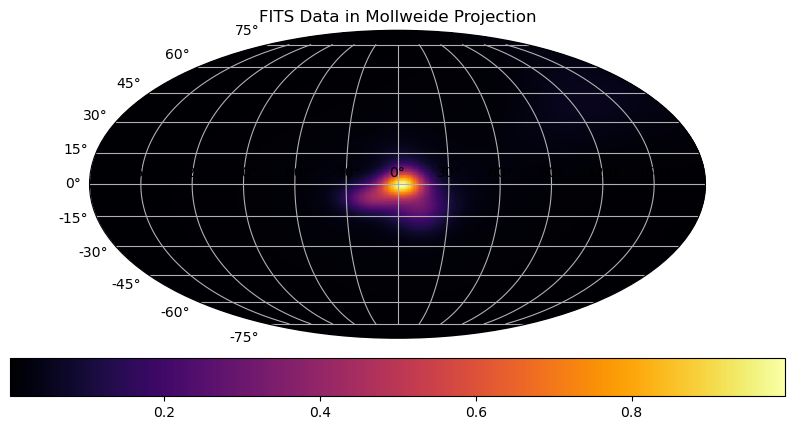

In [6]:


# Create longitude and latitude arrays for the plot
lon = np.linspace(-np.pi, np.pi, image_data.shape[1])
lat = np.linspace(-np.pi / 2, np.pi / 2, image_data.shape[0])

# Create a meshgrid for the plot
lon_grid, lat_grid = np.meshgrid(lon, lat)

# Plot using Mollweide projection
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection='mollweide')

# Plot the image data on the Mollweide projection
c = ax.pcolormesh(lon_grid, lat_grid, image_data, cmap='inferno', shading='auto')

# Add a colorbar
plt.colorbar(c, ax=ax, orientation='horizontal', pad=0.05)
plt.title('FITS Data in Mollweide Projection')
plt.grid(True)
# Plot the image
#plt.imshow(image_data, cmap='gray')
#plt.colorbar()
#plt.title("FITS File Plot")
#plt.show()

# Close the FITS file
hdul.close()



In [7]:
hdul = fits.open(skymap)

# Inspect the contents of the FITS file
hdul.info()

# Extract the image data (assuming it's in the first extension)
image_data = hdul[1].data

# Close the FITS file
hdul.close()

# Define HEALPix parameters (adjust nside based on the resolution of your image)
nside = 64  # This value can be increased for higher resolution
npix = hp.nside2npix(nside)

# Generate an array for the HEALPix map
healpix_map = np.zeros(npix)



Filename: /Users/mseglar/.astropy/cache/download/url/1f17c0cef9c157d77692a6b0d884b2a6/contents
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      43   ()      
  1  PMAP          1 ImageHDU        27   (512, 512)   float64   


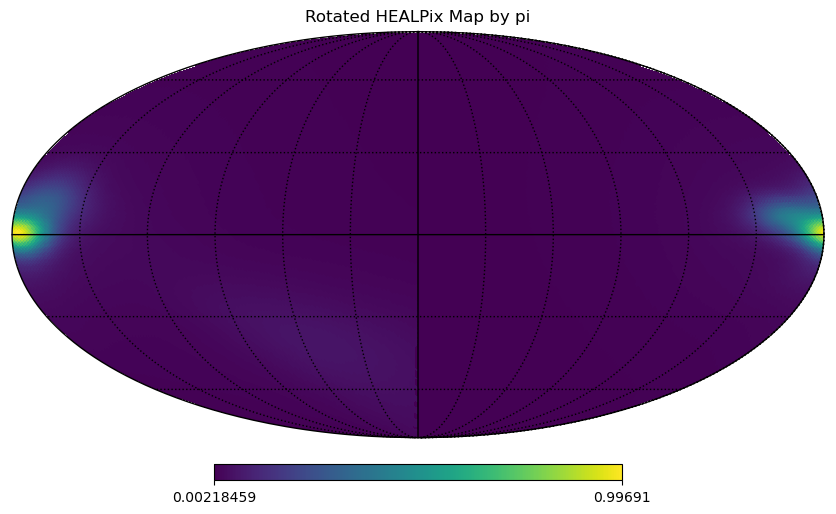

In [8]:
# Convert the pixel positions from the 2D image to HEALPix indices
# This will depend on how the original image represents the sky
for i in range(image_data.shape[0]):
    for j in range(image_data.shape[1]):
        # Convert 2D indices to angles (assuming equirectangular grid)
        # Inverted theta and phi
        #theta = np.pi * (image_data.shape[0] - i - 1) / image_data.shape[0]  # From 0 (South Pole) to pi (North Pole)
        #phi = (j / image_data.shape[1]) * 2 * np.pi -np.pi # From 0 to 2*pi
        
        theta = np.pi * (i) / image_data.shape[0]  # From 0 to pi (polar angle)
        phi = ((image_data.shape[1]-j) / image_data.shape[1]) * 2 * np.pi  # From 0 to 2*pi (longitude)
        
        
        # Convert theta and phi to HEALPix pixel index
        pix_index = hp.ang2pix(nside, theta, phi)
        
        # Assign the value from the image to the HEALPix map
        healpix_map[pix_index] = image_data[i, j]
# Plot the rotated HEALPix map
hp.mollview(healpix_map, title="Rotated HEALPix Map by pi")
# Add grid and labels for latitude and longitude
hp.graticule()

plt.show()

In [9]:
# Create forder for output
if not os.path.exists(outDir):
    os.makedirs(outDir)

In [10]:
#Parse the parameters 
obspar = ObservationParameters()
obspar.add_parsed_args(skymap,obsTime,datasetDir,None,outDir,pointingsFile,alertType)
obspar.from_configfile(cfgFile)

### Run the scheduling

In [12]:
#GetSchedule(obspar)